In [1]:
from PIL import Image
import os
import argparse
import cv2

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from scipy import io

from options import opt_args

from my_transform import Gaussian_Filtering, Scale, Corner_Center_Crop, Target_Scale
from datasets.ShanghaiTech_B import ShanghaiTech_B 
from model import MyModel
from training import train_epoch
from validation import val_epoch
from utils import Logger

In [38]:
model = MyModel(deconv=False)
model.cuda()

checkpoint = torch.load('/home/junya/Documents/crowd_counting/research/saved_model/save_10.pth')
model.load_state_dict(checkpoint['state_dict'])

FileNotFoundError: [Errno 2] No such file or directory: '/home/junya/Documents/crowd_counting/research/saved_model/save_10.pth'

In [ ]:
a = cv2.imread('/mnt/hdd02/ShanghaiTech/part_B/train_data/images/IMG_1.jpg')
a = torch.from_numpy(np.expand_dims(a.transpose(2,0,1), axis=0)).clone().cuda()
a = a.float()

model.eval()
out = model(a)

x = out.to('cpu').detach().numpy().copy().squeeze()

plt.figure()
plt.imshow(x)
plt.show()


In [ ]:
np.max(x)

In [41]:
a = torch.Tensor([[0.2147, 0.1153],
        [0.9430, 0.3856]])

b = torch.Tensor([[0.1153, 0.2147],
        [0.9430, 0.3856]])
print(a)
print(b)

tensor([[0.2147, 0.1153],
        [0.9430, 0.3856]])
tensor([[0.1153, 0.2147],
        [0.9430, 0.3856]])


In [42]:
ce = torch.nn.MSELoss()
loss = ce(a,b)

In [43]:
loss

tensor(0.0049)

In [3]:
def gt_mapping(image, location):
    zeropad = np.zeros((image.size[0],image.size[1]))

    for i in range(0,len(location)):
        if int(location[i][0]) < image.size[0] and int(location[i][1]) < image.size[1]:
            zeropad[int(location[i][0]),int(location[i][1])] = 1
    zeropad = zeropad.T

    return zeropad

In [4]:
def target_loader(image_path):
    mat_path = image_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_')
    with open(mat_path, 'rb') as f:
        return io.loadmat(f)['image_info'][0,0][0,0][0]

In [5]:
image = Image.open('/mnt/hdd02/ShanghaiTech/part_B/train_data/images/IMG_1.jpg')
target = target_loader('/mnt/hdd02/ShanghaiTech/part_B/train_data/images/IMG_1.jpg')
gt_map = gt_mapping(image, target)

In [79]:
gt_map_PIL = Image.fromarray(gt_map)

In [51]:
gf = Gaussion_filtering(15)

In [52]:
dens = gf(gt_map)

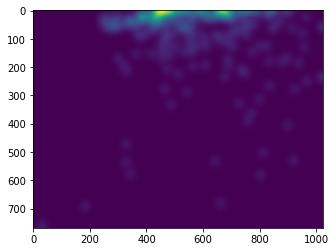

In [53]:
plt.figure()
plt.imshow(dens)
plt.show()

In [57]:
tmp = np.asarray(dens)

In [58]:
tmp.sum()

233.00008

In [72]:
rs = Scale(0.5)
tmp2 = rs(dens)

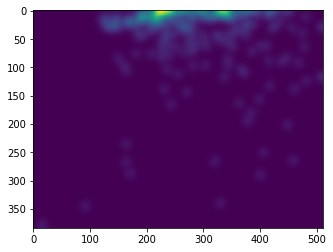

In [73]:
plt.figure()
plt.imshow(tmp2)
plt.show()

In [70]:
tmp2.sum()

57.831318

In [74]:
dec = Scale(2)
tmp3 = dec(tmp2)

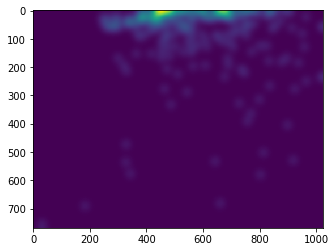

In [75]:
plt.figure()
plt.imshow(tmp3)
plt.show()

In [76]:
np_tmp3 = np.asarray(tmp3)
np_tmp3.sum()

231.32527

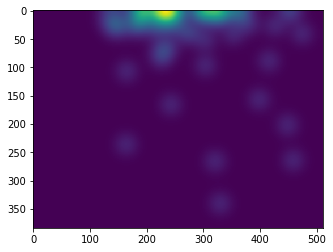

In [84]:
gt_map_PIL_2 = rs(gt_map_PIL)
dens2 = gf(gt_map_PIL_2)
plt.figure()
plt.imshow(dens2)
plt.show()

In [83]:
gt_map_np = np.asarray(gt_map_PIL_2)
gt_map_np.sum()

51.0

In [256]:
import random
import os
from PIL import Image
import numpy as np
import h5py
import cv2

def load_data(img_path,train = True):
    gt_path = img_path.replace('.jpg','.h5').replace('images','ground_truth')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path,'r')
    target = np.asarray(gt_file['density'])
    if train:
        ratio = 0.5
        #crop_size = (int(img.size[0]*ratio),int(img.size[1]*ratio))
        crop_size = (224, 224)
        left_top = (random.randint(0,img.size[0]-crop_size[0]), random.randint(0,img.size[1]-crop_size[1]))
        right_bottom = (left_top[0]+crop_size[0], left_top[1]+crop_size[1])

        """
        if rdn_value<0.25:
            dx = 0
            dy = 0
        elif rdn_value<0.5:
            dx = int(img.size[0]*ratio)
            dy = 0
        elif rdn_value<0.75:
            dx = 0
            dy = int(img.size[1]*ratio)
        else:
            dx = int(img.size[0]*ratio)
            dy = int(img.size[1]*ratio)
        """
        img = img.crop((left_top[0],left_top[1], right_bottom[0], right_bottom[1]))
        target = target[left_top[1]:right_bottom[1],left_top[0]:right_bottom[0]]
        if random.random()>0.8:
            target = np.fliplr(target)
            img = img.transpose(Image.FLIP_LEFT_RIGHT)

    #target = cv2.resize(target,(target.shape[1]//8,target.shape[0]//8),interpolation = cv2.INTER_CUBIC)*64

    return img,target


In [322]:
im, ta = load_data('/mnt/hdd02/ShanghaiTech/part_B/train_data/images/IMG_1.jpg', train=True)

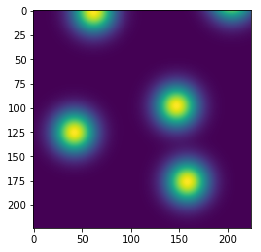

3.741101273883177


In [323]:
plt.figure()
plt.imshow(ta)
plt.show()

print(ta.sum())

In [324]:
print(ta.shape[0]//8)

28


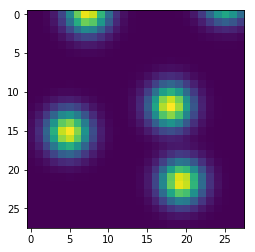

3.7388685


In [325]:
ta = ta*64
ta = Image.fromarray(ta)
ta = ta.resize(size=(ta.size[0]//8,ta.size[1]//8), resample=Image.BICUBIC)
#ta = np.asarray(ta)


plt.figure()
plt.imshow(ta)
plt.show()

ta = np.asarray(ta)
print(ta.sum())

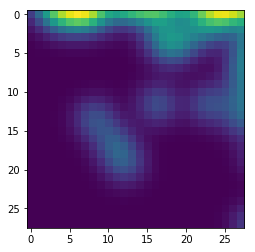

19.425074


In [296]:
ta = ta*64
plt.figure()
plt.imshow(ta)
plt.show()

print(ta.sum())

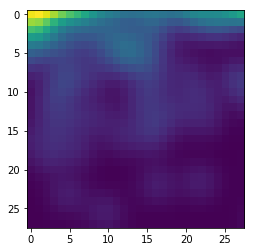

0.9673766782095437


In [283]:
ta = cv2.resize(ta,(ta.shape[1]//8,ta.shape[0]//8),interpolation = cv2.INTER_CUBIC)
plt.figure()
plt.imshow(ta)
plt.show()

print(ta.sum())

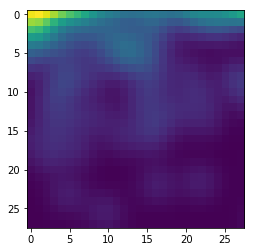

61.912107405410794


In [284]:
ta = ta*64
plt.figure()
plt.imshow(ta)
plt.show()

print(ta.sum())

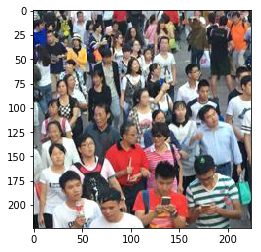

(224, 224)


In [280]:
plt.figure()
plt.imshow(im)
plt.show()

print(im.size)

In [175]:
a = Image.open('/mnt/hdd02/ShanghaiTech/part_A/train_data/images/IMG_156.jpg')
a.size


(1024, 625)

In [2]:
gf = Gaussian_Filtering(15)
crop = Corner_Center_Crop(224,224)
tt = Target_Scale(3)


In [9]:
target_map = gt_mapping(image, target)



In [10]:
target_map

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
ta = gf(target_map)
crop.randomize_parameters()

ta = crop(ta)
ta = tt(ta)

In [14]:
ta.size

(74, 74)

In [ ]:
a = loadmat()